In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import requests
from sklearn import datasets
from sklearn import preprocessing
from tensorflow.python.framework import ops
ops.reset_default_graph()
sess = tf.Session()

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['weatherAUS.csv']


In [2]:
data = pd.read_csv('../input/weatherAUS.csv')
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [3]:
data.drop(['Evaporation','Sunshine','Cloud9am','Cloud3pm','RISK_MM','Date','Location'],axis=1,inplace=True)
data.dropna(inplace=True)
data[['RainTomorrow','RainToday']] = data[['RainTomorrow','RainToday']].replace({'No':0,'Yes':1})
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112925 entries, 0 to 142192
Data columns (total 17 columns):
MinTemp          112925 non-null float64
MaxTemp          112925 non-null float64
Rainfall         112925 non-null float64
WindGustDir      112925 non-null object
WindGustSpeed    112925 non-null float64
WindDir9am       112925 non-null object
WindDir3pm       112925 non-null object
WindSpeed9am     112925 non-null float64
WindSpeed3pm     112925 non-null float64
Humidity9am      112925 non-null float64
Humidity3pm      112925 non-null float64
Pressure9am      112925 non-null float64
Pressure3pm      112925 non-null float64
Temp9am          112925 non-null float64
Temp3pm          112925 non-null float64
RainToday        112925 non-null int64
RainTomorrow     112925 non-null int64
dtypes: float64(12), int64(2), object(3)
memory usage: 15.5+ MB
None


,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0,0
1,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0,0
2,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0,0
3,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0,0
4,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0,0


In [4]:
categorical_columns = ['WindGustDir', 'WindDir3pm', 'WindDir9am']
data = pd.get_dummies(data, columns=categorical_columns)
x_vals = data.drop(['RainTomorrow'],axis=1)
y_vals = data['RainTomorrow']
x_vals.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
0,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
from sklearn.model_selection import train_test_split
x_vals_train, x_vals_test, y_vals_train, y_vals_test = train_test_split(x_vals, y_vals, test_size=0.20, random_state=88)
x_vals_train.head()
#x_vals_test.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
78802,10.8,16.4,20.6,72.0,19.0,35.0,96.0,83.0,998.5,991.5,12.1,12.9,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
134085,14.7,27.1,0.0,43.0,30.0,26.0,27.0,21.0,1022.1,1019.4,20.5,26.1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
119133,11.8,20.8,0.0,39.0,15.0,13.0,47.0,50.0,1017.5,1012.9,14.8,20.5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
10543,10.9,23.8,0.0,39.0,9.0,28.0,49.0,56.0,1027.4,1024.4,20.9,22.4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
12866,16.2,24.5,50.8,59.0,7.0,15.0,76.0,65.0,1009.5,1007.4,19.0,22.8,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [6]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaler.fit(x_vals_train)
x_vals_train = np.array(pd.DataFrame(scaler.transform(x_vals_train), index=x_vals_train.index, columns=x_vals_train.columns))
x_vals_test = np.array(pd.DataFrame(scaler.transform(x_vals_test), index=x_vals_test.index, columns=x_vals_test.columns))
print(x_vals_train)

[[0.45130641 0.30872483 0.05603917 ... 0.         0.         0.        ]
 [0.54394299 0.54809843 0.         ... 0.         0.         0.        ]
 [0.47505938 0.40715884 0.         ... 0.         0.         0.        ]
 ...
 [0.55106888 0.43176734 0.09793254 ... 0.         0.         0.        ]
 [0.19714964 0.25727069 0.         ... 0.         1.         0.        ]
 [0.20902613 0.20581655 0.05603917 ... 0.         0.         0.        ]]


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [8]:
batch_size = 25
x_data = tf.placeholder(shape=[None, 61],dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1],dtype=tf.float32)
A = tf.Variable(tf.random_normal(shape=[61,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))
#b = tf.Variable(tf.zeros(1))
model_output = tf.add(tf.matmul(x_data,A),b)

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))
init = tf.global_variables_initializer()
sess.run(init)
my_opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train_step = my_opt.minimize(loss)

prediction = tf.round(tf.sigmoid(model_output))
prediction_correct = tf.cast(tf.equal(prediction,y_target),tf.float32)
accuracy = tf.reduce_mean(prediction_correct)

loss_vec = []
train_acc = []
test_acc = []
for i in range(1500):
    rand_index = np.random.choice(len(x_vals_train),size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step,feed_dict={x_data: rand_x,y_target: rand_y})
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x,y_target: rand_y})
    loss_vec.append(temp_loss)
    temp_acc_train = sess.run(accuracy,feed_dict={x_data: x_vals_train, y_target: np.transpose([y_vals_train])})
    train_acc.append(temp_loss)
    temp_acc_test = sess.run(accuracy,feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
    test_acc.append(temp_acc_test)


/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


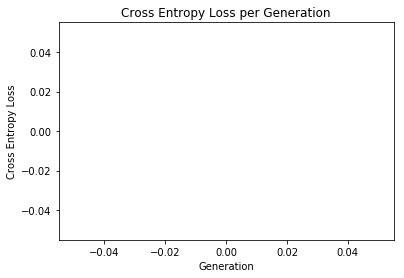

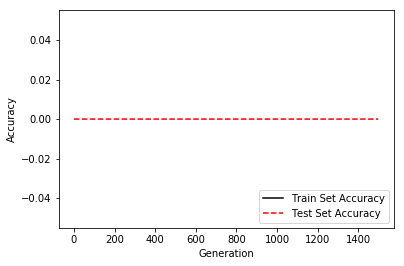

In [9]:
plt.plot(loss_vec,'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()
plt.plot(train_acc,'k-',label='Train Set Accuracy')
plt.plot(test_acc,'r--',label='Test Set Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()